In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        (os.path.join(dirname, filename))
print("DONE")
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

DONE


## Semantic Segmentation on PASCAL VOC 2012 dataset


In [ ]:
!pip install -q timm
print("DOne")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 88.4 MB/s eta 0:00:00
DOne


In [ ]:
import os
import torch
import torch.nn as nn
import timm
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm



In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
print(device)

cuda


In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import timm
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
## Preparing dataset
## Define the Pascal VOC dataset class

class PascalVOCDataset(Dataset):
    def __init__(self, root, split="train", image_size=(518, 518)):
        self.image_dir = os.path.join(root, "JPEGImages")
        self.mask_dir = os.path.join(root, "SegmentationClass")
        split_file = os.path.join(root, "ImageSets", "Segmentation", f"{split}.txt")

        with open(split_file, "r") as f:
            self.image_ids = [line.strip() for line in f.readlines()]

        self.img_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])
        self.mask_transform = transforms.Compose([
            transforms.Resize(image_size, interpolation=Image.NEAREST),
            transforms.PILToTensor()
        ])

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        img = Image.open(os.path.join(self.image_dir, f"{img_id}.jpg")).convert("RGB")
        mask = Image.open(os.path.join(self.mask_dir, f"{img_id}.png"))

        img = self.img_transform(img)
        mask = self.mask_transform(mask).squeeze(0).long()

        return img, mask

In [ ]:
### Model Definition

class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.block(x)

class UNetDecoder(nn.Module):
    def __init__(self, input_ch, num_classes):
        super().__init__()
        self.up1 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            ConvBlock(input_ch, 512)
        )
        self.up2 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            ConvBlock(512, 256)
        )
        self.up3 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            ConvBlock(256, 128)
        )
        self.up4 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            ConvBlock(128, 64)
        )
        self.final = nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, x):
        x = self.up1(x)
        x = self.up2(x)
        x = self.up3(x)
        x = self.up4(x)
        return self.final(x)


# Combining DINOv2 Backbone + UNet Model

class DinoUNet(nn.Module):
    def __init__(self, num_classes=21):
        super().__init__()
        self.backbone = timm.create_model(
            "vit_base_patch14_dinov2.lvd142m",
            pretrained=True,
            features_only=True
        )
        for param in self.backbone.parameters():
            param.requires_grad = False

        for name, param in self.backbone.named_parameters():
            if "blocks.11" in name:
                param.requires_grad = True
        self.decoder = UNetDecoder(input_ch=768, num_classes=num_classes)

    def forward(self, x):
        feats = self.backbone(x)[-1]  ## ExPected dim: B, 768, 16, 16
        out = self.decoder(feats)
        return out

In [ ]:
# Loss function and Evaluation metric

###  Lovasz Softmax
def lovasz_grad(gt_sorted):
    gts = gt_sorted.sum()
    intersection = gts - gt_sorted.float().cumsum(0)
    union = gts + (1 - gt_sorted).float().cumsum(0)
    jaccard = 1. - intersection / union
    jaccard[1:] = jaccard[1:] - jaccard[:-1]
    return jaccard

def lovasz_softmax_flat(probs, labels, classes='present'):
    if probs.numel() == 0:
        return probs * 0.
    C = probs.size(1)
    losses = []
    for c in range(C):
        fg = (labels == c).float()
        if classes == 'present' and fg.sum() == 0:
            continue
        errors = (fg - probs[:, c]).abs()
        errors_sorted, perm = torch.sort(errors, descending=True)
        fg_sorted = fg[perm]
        grad = lovasz_grad(fg_sorted)
        loss = torch.dot(errors_sorted, grad)
        losses.append(loss)
    if len(losses) == 0:
        return torch.tensor(0., device=probs.device)
    return sum(losses) / len(losses)

class LovaszSoftmaxLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, logits, labels):
        probs = F.softmax(logits, dim=1).permute(0,2,3,1).contiguous().view(-1, logits.shape[1])
        labels_flat = labels.view(-1)
        return lovasz_softmax_flat(probs, labels_flat)

### Pxl-wise Acc
def pixel_accuracy(preds, masks):
    preds = torch.argmax(preds, dim=1)
    valid = (masks != 255)
    correct = (preds == masks) & valid
    return correct.sum().item() / valid.sum().item()


In [ ]:
### IoU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

data_root = "/kaggle/input/pascal-voc-2012/VOC2012"  # Change to your VOC2012 path
train_dataset = PascalVOCDataset(data_root, split="train", image_size=(518, 518))
val_dataset = PascalVOCDataset(data_root, split="val", image_size=(518, 518))

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, num_workers=2)

model = DinoUNet(num_classes=21).to(device)
criterion = LovaszSoftmaxLoss()
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)


def compute_iou(preds, labels, num_classes=21, ignore_index=255):
    preds = torch.argmax(preds, dim=1).view(-1)
    labels = labels.view(-1)

    mask = labels != ignore_index
    preds = preds[mask]
    labels = labels[mask]

    hist = torch.bincount(
        num_classes * labels + preds, minlength=num_classes**2
    ).reshape(num_classes, num_classes).float()

    intersection = torch.diag(hist)
    union = hist.sum(1) + hist.sum(0) - intersection
    iou = intersection / union.clamp(min=1e-6)
    return iou.cpu().numpy(), iou.mean().item()

def denormalize(img):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1).to(img.device)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1).to(img.device)
    img = img * std + mean
    return img.clamp(0, 1)


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]


Epoch 1/8


100%|██████████| 732/732 [04:04<00:00,  2.99it/s]

Train Loss: 0.6927


Validation Pixel Accuracy: 0.7481
Validation mIoU: 0.0868


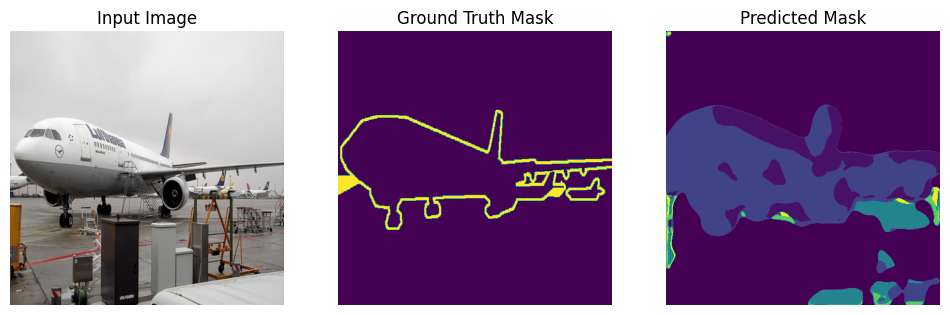

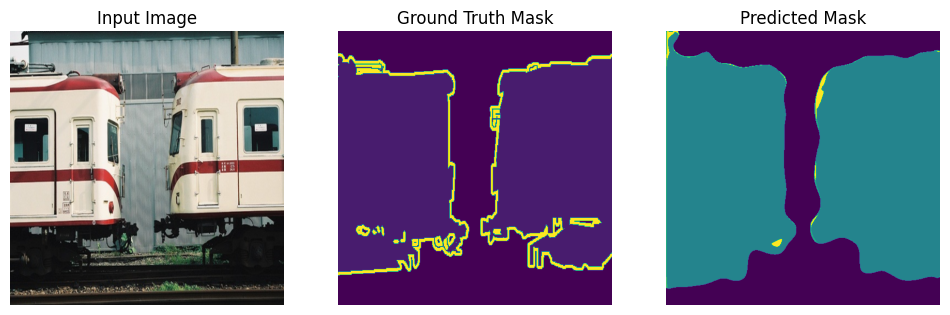

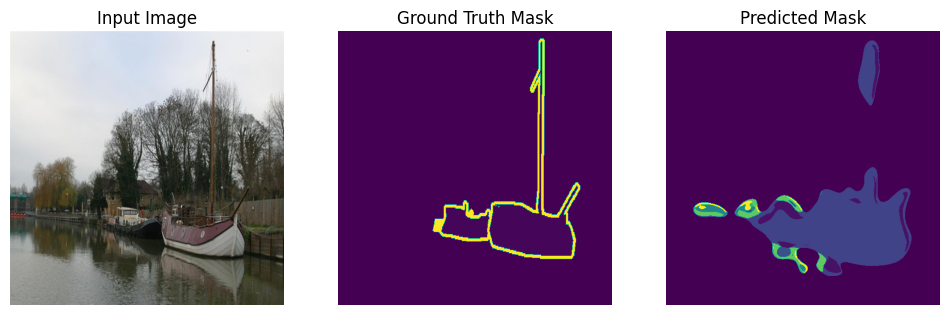


Epoch 2/8


100%|██████████| 732/732 [04:03<00:00,  3.00it/s]

Train Loss: 0.5166


Validation Pixel Accuracy: 0.8150
Validation mIoU: 0.1073


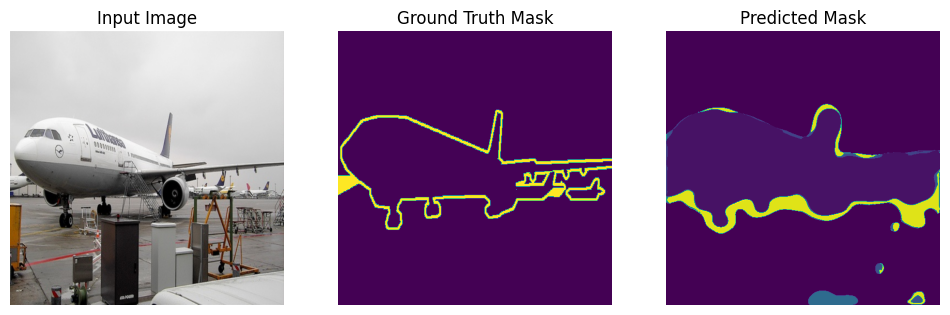

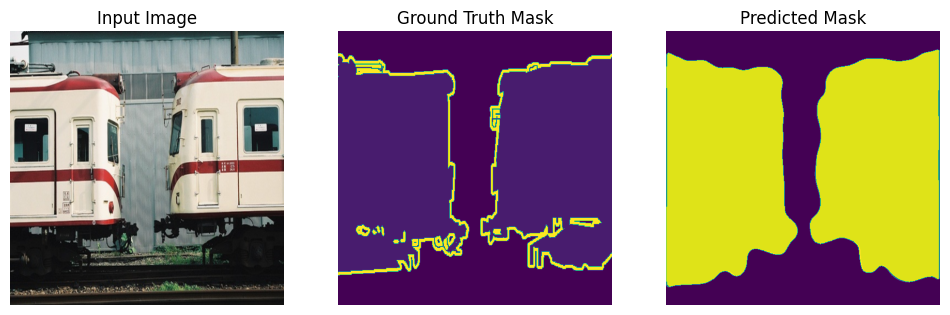

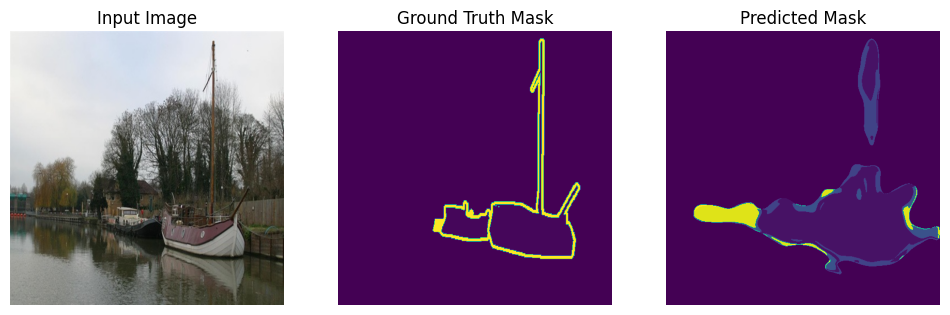


Epoch 3/8


100%|██████████| 732/732 [04:04<00:00,  3.00it/s]

Train Loss: 0.4497


Validation Pixel Accuracy: 0.8839
Validation mIoU: 0.1196


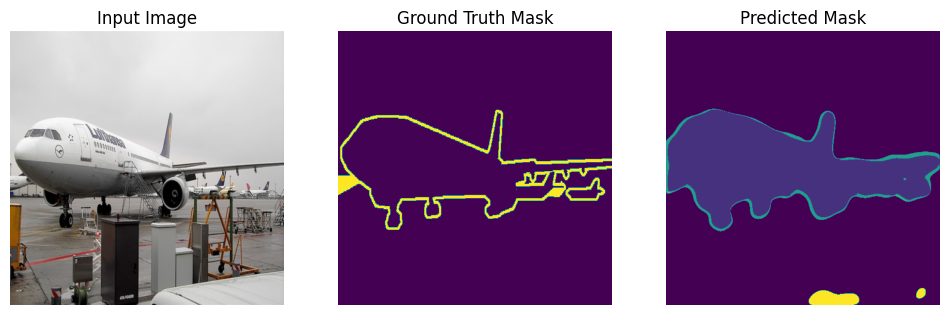

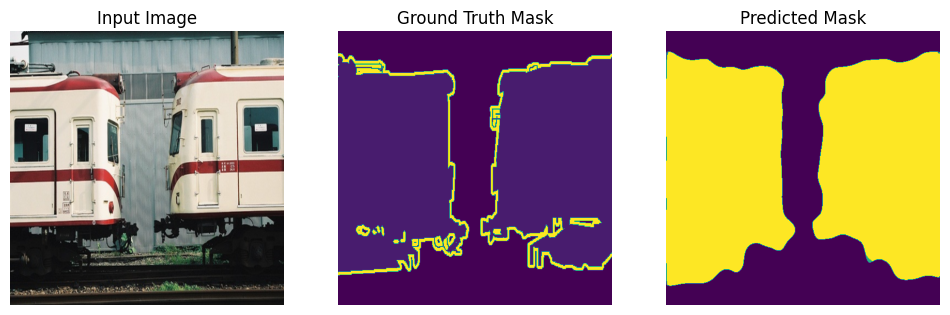

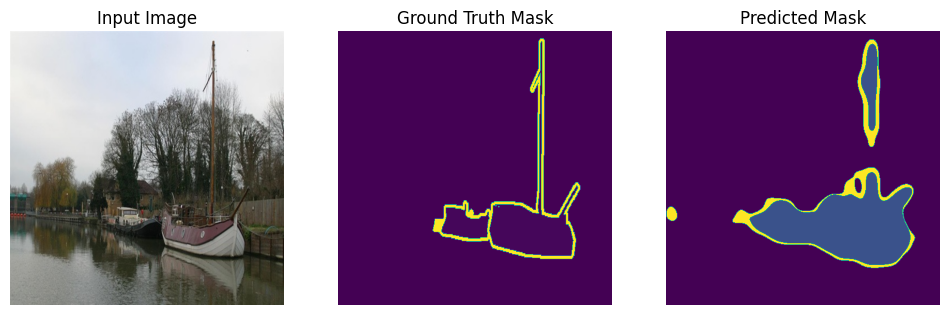


Epoch 4/8


100%|██████████| 732/732 [04:04<00:00,  3.00it/s]

Train Loss: 0.3999


Validation Pixel Accuracy: 0.8839
Validation mIoU: 0.1202


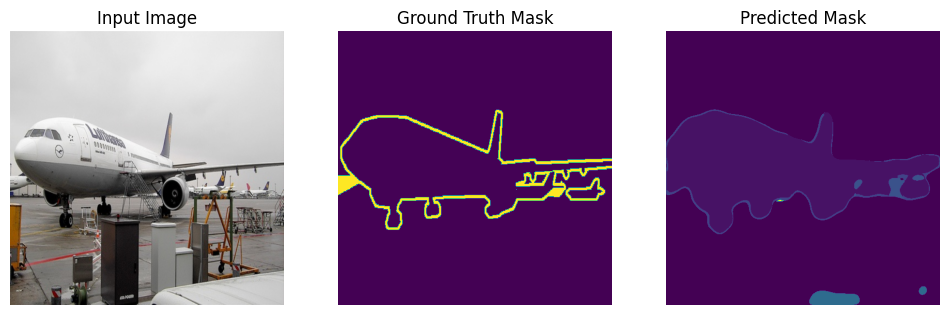

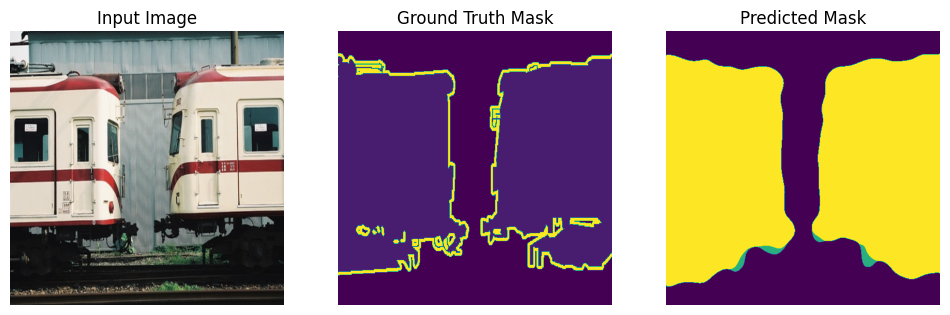

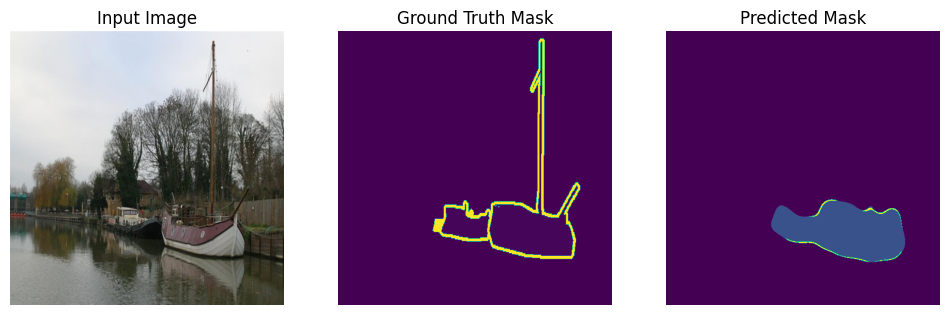


Epoch 5/8


100%|██████████| 732/732 [04:04<00:00,  3.00it/s]

Train Loss: 0.3499


Validation Pixel Accuracy: 0.9125
Validation mIoU: 0.1290


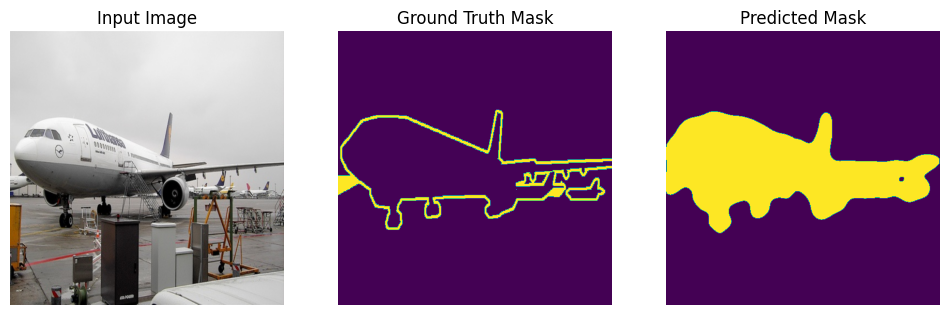

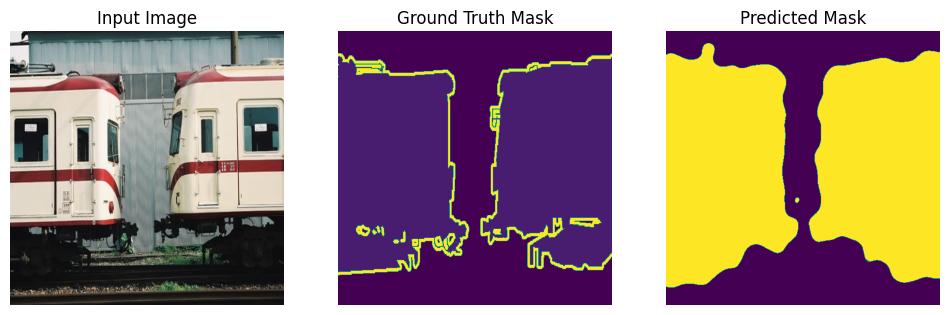

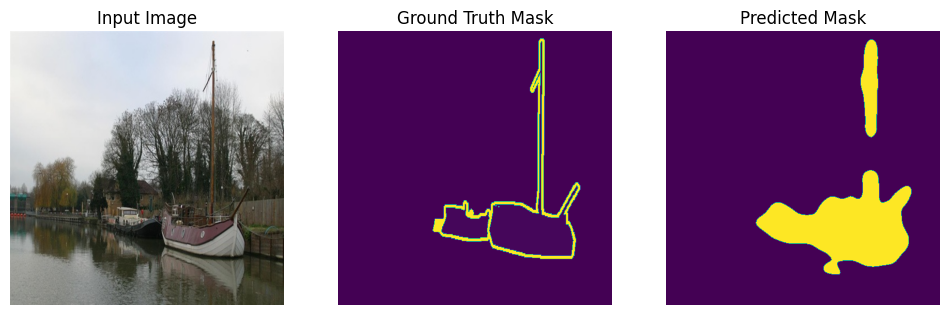


Epoch 6/8


100%|██████████| 732/732 [04:04<00:00,  2.99it/s]

Train Loss: 0.3193


Validation Pixel Accuracy: 0.9350
Validation mIoU: 0.1361


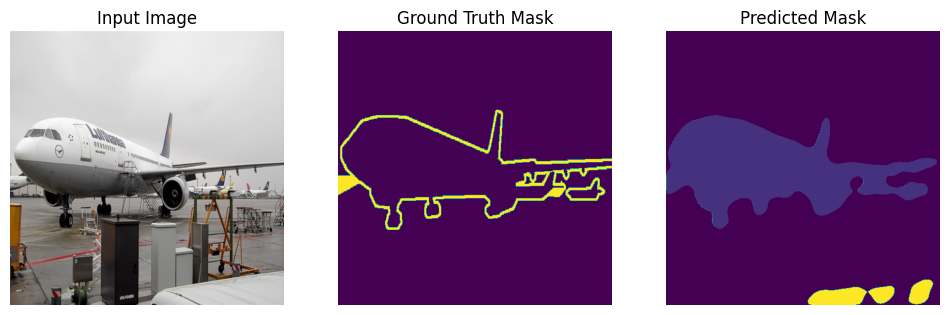

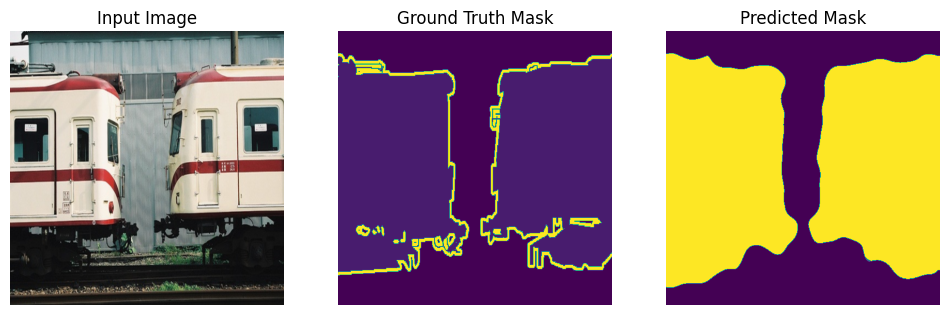

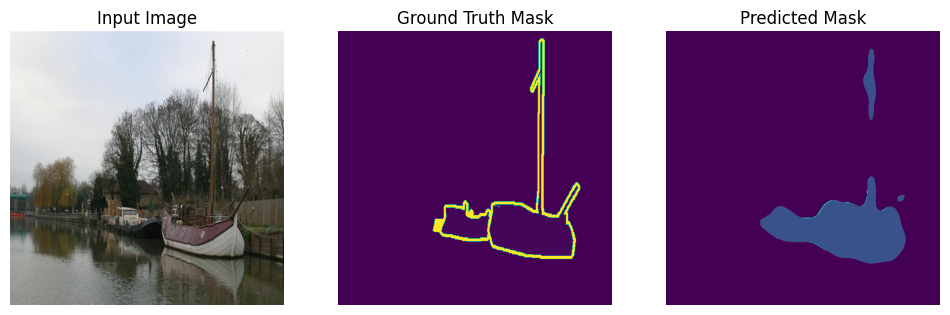


Epoch 7/8


100%|██████████| 732/732 [04:04<00:00,  3.00it/s]

Train Loss: 0.2882


Validation Pixel Accuracy: 0.9426
Validation mIoU: 0.1376


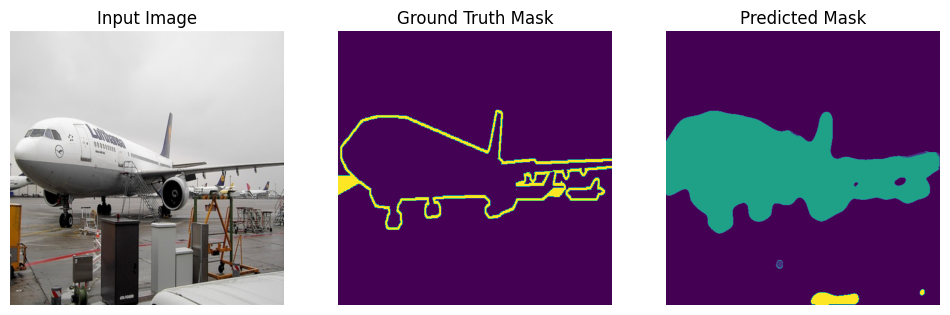

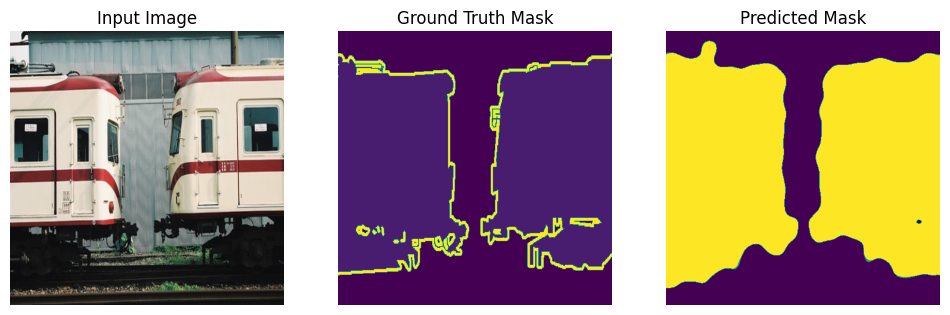

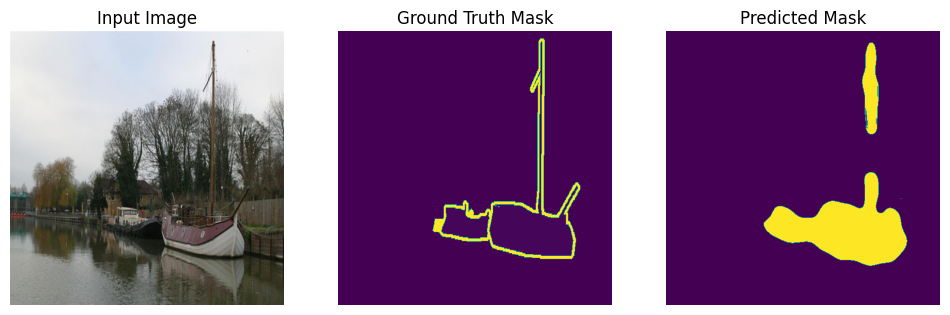


Epoch 8/8


100%|██████████| 732/732 [04:04<00:00,  3.00it/s]

Train Loss: 0.2659


Validation Pixel Accuracy: 0.9368
Validation mIoU: 0.1373


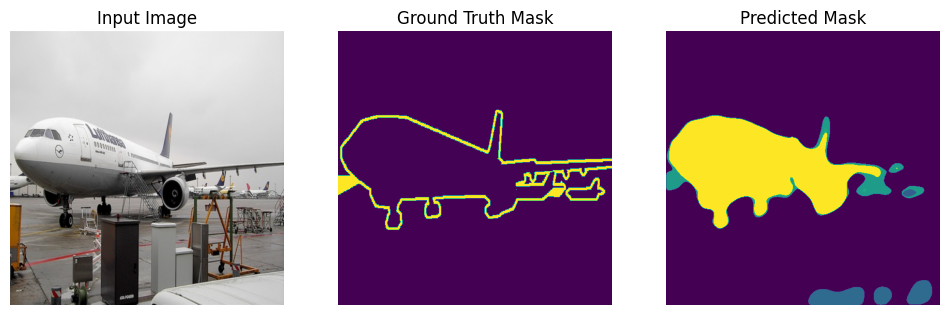

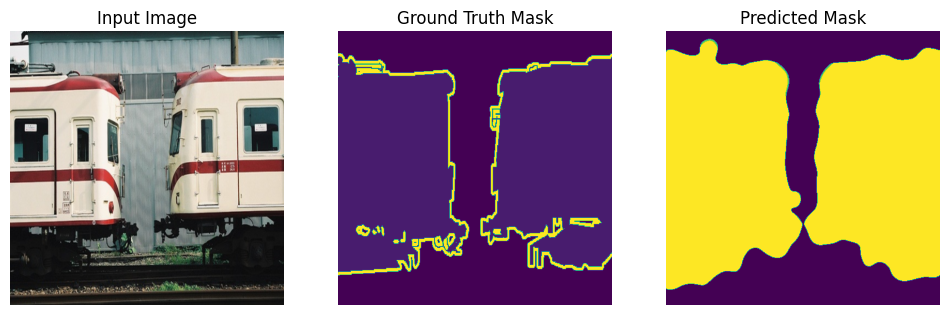

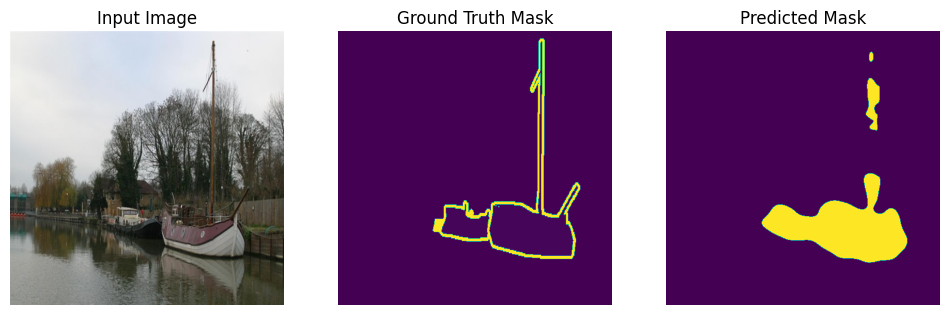

In [ ]:
#3# 7. tr and val loop

num_epochs = 8

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    print(f"\nEpoch {epoch+1}/{num_epochs}")

    # Training loop
    for i, (imgs, masks) in enumerate(tqdm(train_loader)):
        imgs, masks = imgs.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        # Resize outputs to match mask size
        outputs = F.interpolate(outputs, size=masks.shape[1:], mode='bilinear', align_corners=False)

        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Train Loss: {avg_loss:.4f}")

    # Validation loop
    model.eval()
    val_acc = 0.0
    iou_total = []

    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs, masks = imgs.to(device), masks.to(device)

            outputs = model(imgs)
            outputs = F.interpolate(outputs, size=masks.shape[1:], mode='bilinear', align_corners=False)

            val_acc += pixel_accuracy(outputs, masks)

            iou, _ = compute_iou(outputs, masks)
            iou_total.append(iou)

    val_acc /= len(val_loader)
    mean_iou = np.mean(iou_total, axis=0)

    print(f"Validation Pixel Accuracy: {val_acc:.4f}")
    print(f"Validation mIoU: {mean_iou.mean():.4f}")

    # Visualize 3 examples from validation dataset
    for i in range(3):
        img, mask = val_dataset[i]
        with torch.no_grad():
            pred = model(img.unsqueeze(0).to(device))
            pred = F.interpolate(pred, size=mask.shape, mode='bilinear', align_corners=False)
            pred_mask = torch.argmax(pred.squeeze(), dim=0).cpu().numpy()

        plt.figure(figsize=(12, 4))

        plt.subplot(1, 3, 1)
        plt.title("Input Image")
        plt.imshow(denormalize(img).permute(1, 2, 0).cpu().numpy())
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.title("Ground Truth Mask")
        plt.imshow(mask.cpu().numpy())
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.title("Predicted Mask")
        plt.imshow(pred_mask)
        plt.axis('off')

        plt.show()




In [ ]:
torch.save(model.state_dict(), "dinounet_weights_ep_8.pth")


In [1]:
print("hello , ")

hello , 
